We want to $c\in [250, 300]$

# Data Generation : Uniform Field

* First order finite element with $100 \times 100$ computational domain, namely $101$ points in each edge 
* $\omega = 1000$
* The random $c$ field is generated as 
$$ c(\theta) = 250 + \theta$$
Assuming that $ \theta \sim \mathcal{U}[0, 50]$ 



# Data Generation : Random Field

* First order finite element with $100 \times 100$ computational domain, namely $101$ points in each edge 
* $\omega = 1000$
* The random $c$ field is generated as 
$$ c(x, \theta) = 95 + 95 \times 1_{a(x, \theta) > 0}$$
Assuming that $ a(x, \theta)$ is a centred Gaussian with covariance 
$$\mathsf{C} = (-\Delta + \tau^2 )^{-d};$$
here $-\Delta$ denotes the Laplacian on $D$ subject to homogeneous Neumann boundary conditions on the space of spatial-mean zero functions, 
$\tau > 0$ denotes the inverse length scale of the random field and $d  > 0$ determines its regularity.
The Gaussian field can be represented by the Karhunen–Loève (KL) expansion
\begin{equation}
\label{eq:KL-2d}
     a(x,\theta) = \sum_{l\in K} \theta_{(l)}\sqrt{\lambda_l} \psi_l(x),
\end{equation}
where $K = \mathcal{Z}^{0+}\times\mathcal{Z}^{0+} \setminus \{0,0\}$, and the eigenpairs are of the form
$$
\begin{equation*}
    \psi_l(x) = \begin{cases}
                 \sqrt{2}\cos(\pi l_1 x_1)              & l_2 = 0\\
                 \sqrt{2}\cos(\pi l_2 x_2)              & l_1 = 0\\
                 2\cos(\pi l_1 x_1)\cos(\pi l_2 x_2)    & \textrm{otherwise}\\
                 \end{cases},
                 \qquad \lambda_l = (\pi^2 |l|^2 + \tau^2)^{-d}
\end{equation*}
$$
and $\theta_{(l)} \sim \mathcal{N}(0,1)$ i.i.d. The KL expansion can be rewritten as a sum over $\mathcal{Z}^{0+}$ rather than a lattice: 
$$
\begin{equation}
\label{eq:KL-1d}
     a(x,\theta) = \sum_{k\in \mathcal{Z}^{0+}} \theta_{(k)}\sqrt{\lambda_k} \psi_k(x),
\end{equation}
$$
where the eigenvalues $\lambda_k$ are in descending order.
In practice, we truncate this sum to $N_\theta$ terms, based on the
largest $N_\theta$ eigenvalues, and hence $\theta\in\mathcal{R}^{N_\theta}$.
 



In [85]:
using Random, Distributions, NPZ
include("Box_Neumann_To_Dirichlet.jl")


function c_func_uniform(θ::Float64) 
    
    c = 250 + θ 
    
    return c
end



#=
Compute sorted pair (i, j), sorted by i^2 + j^2
wInt64h i≥0 and j≥0 and i+j>0

These pairs are used for Karhunen–Loève expansion
=#
function compute_seq_pairs(N_KL::Int64) 
    seq_pairs = zeros(Int64, N_KL, 2)
    trunc_Nx = trunc(Int64, sqrt(2*N_KL)) + 1
    
    include_00 = false
    seq_pairs = zeros(Int64, (trunc_Nx+1)^2 - 1 + include_00, 2)
    seq_pairs_mag = zeros(Int64, (trunc_Nx+1)^2 - 1 + include_00)
    
    seq_pairs_i = 0
    for i = 0:trunc_Nx
        for j = 0:trunc_Nx
            if (i == 0 && j ==0 && ~include_00)
                continue
            end
            seq_pairs_i += 1
            seq_pairs[seq_pairs_i, :] .= i, j
            seq_pairs_mag[seq_pairs_i] = i^2 + j^2
        end
    end
    
    seq_pairs = seq_pairs[sortperm(seq_pairs_mag), :]
    return seq_pairs[1:N_KL, :]
end


#=
Generate parameters for logk field, based on Karhunen–Loève expansion.
They include eigenfunctions φ, eigenvalues λ and the reference parameters θ_ref, 
and reference field logk_2d field

logκ = ∑ u_l √λ_l φ_l(x)                l = (l₁,l₂) ∈ Z^{0+}×Z^{0+} \ (0,0)

where φ_{l}(x) = √2 cos(πl₁x₁)             l₂ = 0
                 √2 cos(πl₂x₂)             l₁ = 0
                 2  cos(πl₁x₁)cos(πl₂x₂) 
      λ_{l} = (π^2l^2 + τ^2)^{-d} 

They can be sorted, where the eigenvalues λ_{l} are in descending order

generate_θ_KL function generates the summation of the first N_KL terms 
=#
function c_func_random(x1::Float64, x2::Float64, θ::Array{Float64, 1}, seq_pairs::Array{Int64, 2}, d::Float64=2.0, τ::Float64=3.0) 
    
    N_KL = length(θ)
    
    a = 0
    
    for i = 1:N_KL
        λ = (pi^2*(seq_pairs[i, 1]^2 + seq_pairs[i, 2]^2) + τ^2)^(-d)
        
        if (seq_pairs[i, 1] == 0 && seq_pairs[i, 2] == 0)
            a += θ[i] * sqrt(λ)
        elseif (seq_pairs[i, 1] == 0)
            a += θ[i] * sqrt(λ) * sqrt(2)*cos.(pi * (seq_pairs[i, 2]*x2))
        elseif (seq_pairs[i, 2] == 0)
            a += θ[i] * sqrt(λ) * sqrt(2)*cos.(pi * (seq_pairs[i, 1]*x1))
        else
            a += θ[i] * sqrt(λ) * 2*cos.(pi * (seq_pairs[i, 1]*x1)) .*  cos.(pi * (seq_pairs[i, 2]*x2))
        end

        
    end
       
    # c = 275 .+ 25*a
    
    c = 95 .+ 95*(a > 0.0)
    
    return c
end


function compute_a_field(xx::Array{Float64,1}, θ::Array{Float64, 1}, seq_pairs::Array{Int64, 2}, d::Float64=2.0, τ::Float64=3.0)
    N = length(xx)
    X,Y = repeat(xx, 1, N), repeat(xx, 1, N)'
    
    N_KL = length(θ)
    φ = zeros(Float64, N_KL, N, N)
    λ = zeros(Float64, N_KL)
    
    
    for i = 1:N_KL
        if (seq_pairs[i, 1] == 0 && seq_pairs[i, 2] == 0)
            φ[i, :, :] .= 1.0
        elseif (seq_pairs[i, 1] == 0)
            φ[i, :, :] = sqrt(2)*cos.(pi * (seq_pairs[i, 2]*Y))
        elseif (seq_pairs[i, 2] == 0)
            φ[i, :, :] = sqrt(2)*cos.(pi * (seq_pairs[i, 1]*X))
        else
            φ[i, :, :] = 2*cos.(pi * (seq_pairs[i, 1]*X)) .*  cos.(pi * (seq_pairs[i, 2]*Y))
        end

        λ[i] = (pi^2*(seq_pairs[i, 1]^2 + seq_pairs[i, 2]^2) + τ^2)^(-d)
    end
    

    loga_2d = zeros(Float64, N, N)
    for i = 1:N_KL
        loga_2d .+= θ[i]*sqrt(λ[i])*φ[i, :, :]
    end
    
    return loga_2d
    
end



function Data_Generate(generate_method::String, data_type::String, N_data::Int64, N_θ::Int64; prefix::String="",
    ne::Int64 = 100,   seed::Int64=123)
    @assert(generate_method == "Uniform" || generate_method == "Random")
    @assert(data_type == "Direct" || generate_method == "Indirect")
    
    porder = 1
    Δx = 1.0/ne
    K_scale = zeros(Float64, ne*porder+1) .+ Δx
    K_scale[1] = K_scale[end] = Δx/2.0
    Random.seed!(seed)

    if generate_method == "Uniform" && data_type == "Direct"
        N_θ = 1
        θ = rand(Uniform(0, 50), N_data, N_θ);
        κ = zeros(ne+1, ne+1, N_data)
        for i = 1:N_data
            cs = [(x,y)->c_func_uniform(θ[i]);]
            # generate Dirichlet to Neumman results output for different condInt64ions
            # data =[nodal posInt64ions, (x, ∂u∂n, u), 4 edges, experiment number]
            data = Generate_Input_Output(cs, ne, porder);
            
            # data =[nodal posInt64ions, (x, ∂u∂n, u), 4 edges, experiment number]
            bc_id = 3
            u_n = data[:, 2, bc_id, :]
            u_d = data[:, 3, bc_id, :]
            K = u_d/u_n
            κ[:, :, i] = K ./ K_scale' 
        end 
        
        npzwrite(prefix*"uniform_direct_theta.npy", θ)
        npzwrite(prefix*"uniform_direct_K.npy", κ)

    elseif generate_method == "Random" && data_type == "Direct"
        N_θ = 8
        θ = rand(Normal(0, 1.0), N_data, N_θ);
        κ = zeros(ne+1, ne+1, N_data)

        seq_pairs = compute_seq_pairs(N_θ)
        Threads.@threads for i = 1:N_data
            @info "i = ", i
            cs = [(x,y)->c_func_random(x, y, θ[i, :], seq_pairs);]

            # generate Dirichlet to Neumman results output for different condInt64ions
            # data =[nodal posInt64ions, (x, ∂u∂n, u), 4 edges, experiment number]
            data = Generate_Input_Output(cs, ne, porder);
            
            # data =[nodal posInt64ions, (x, ∂u∂n, u), 4 edges, experiment number]
            bc_id = 3
            u_n = data[:, 2, bc_id, :]
            u_d = data[:, 3, bc_id, :]
            K = u_d/u_n
            κ[:, :, i] = K ./ K_scale' 
        end 
        
        npzwrite(prefix*"random_direct_theta.npy", θ)
        npzwrite(prefix*"random_direct_K.npy", κ)

    else 
        @info "generate_method: $(generate_method) and data_type == $(data_type) have not implemented yet"
    end
    
    return θ, κ
    
    
end

Data_Generate (generic function with 1 method)

# Direct Data

The data pairs are $\{\theta, K \}$, here K is a $101 \times 101$ matrix, which stores $\kappa(x_i, x_j)$

# Indirect Data
The data pairs are $\{\theta, u_n, u_d \}$

# Neural Network
The neural network 

$$NN: (\theta, x, y) \rightarrow \kappa_{\theta}(x, y)$$


In [77]:
θ, κ = Data_Generate("Random", "Direct", 3, 8; ne=100)

┌ Info: ("i = ", 1)
└ @ Main In[74]:165
┌ Info: ("i = ", 2)
└ @ Main In[74]:165
┌ Info: ("i = ", 3)
└ @ Main In[74]:165


([1.1902678809862768 0.45941562040708034 … -0.7174100165743348 0.26040229778962753; 2.04817970778924 -0.396679079295223 … -0.775069863870378 -0.46848914917290574; 1.142650902867199 -0.6647125451916877 … -0.9795392068942285 -0.8808972481620518], [1.67226336074122 0.8806302454495537 … -0.4217530352522568 -0.42061231084792133; 0.8806301033440114 1.0060320284316728 … -0.42122643091001477 -0.4200941635644899; … ; -0.4212005155437305 -0.4206742707829193 … -2.4790736585865263 -2.6085259305937187; -0.4200591348582125 -0.419541346634347 … -2.6085264421635563 -1.820948936100224]

[1.2890028518736336 0.4983177570735764 … -0.25050332063364517 -0.2490929549016983; 0.4983178753972983 0.6246648180291285 … -0.2506773736863846 -0.24927721909832012; … ; -0.25009486540909426 -0.2502706088464811 … 0.6419500902368905 0.5170934549758887; -0.24868413174643483 -0.24887008807672337 … 0.5170941098740018 1.3092743411761667]

[2.8458180351003435 2.0488446440246992 … -0.4346464950314715 -0.4362722473318898; 2.0488

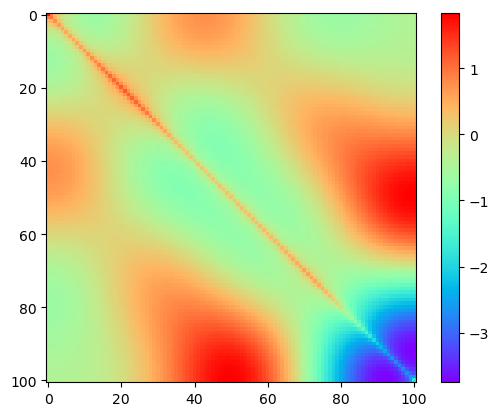

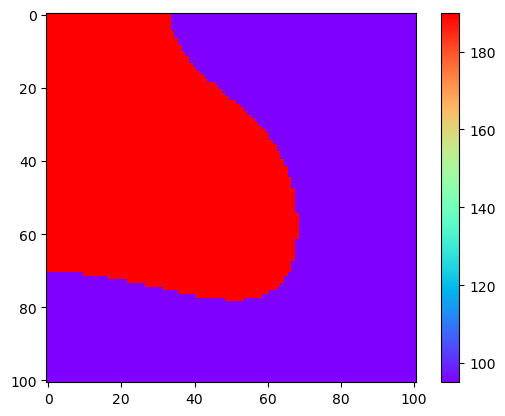

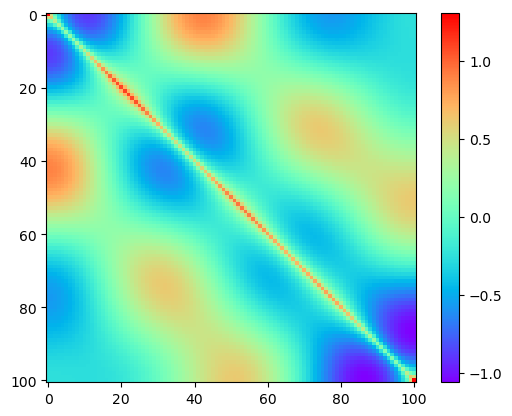

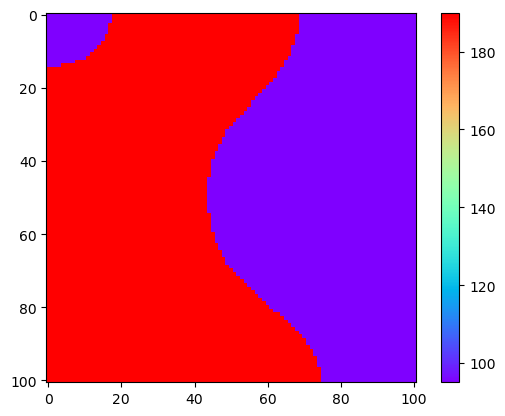

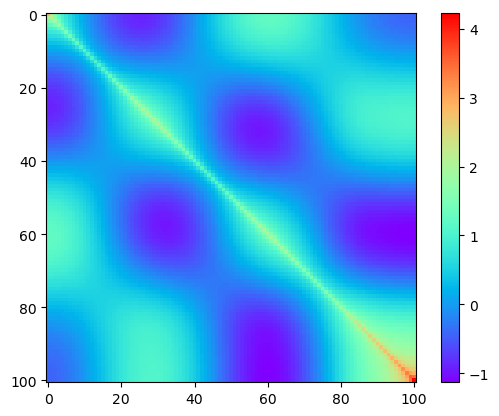

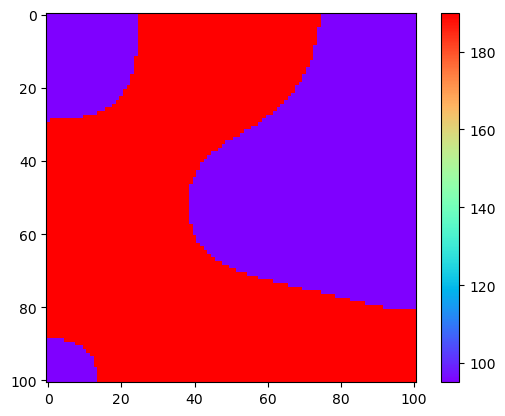

In [81]:
PyPlot.close("all")
for i = 1:3
    PyPlot.figure()
    PyPlot.imshow(κ[:,:,i], cmap=:rainbow)
    PyPlot.colorbar()

    a = compute_a_field(xx, θ[i, :], seq_pairs, 0.0)
    PyPlot.figure()
    PyPlot.imshow(95 .+ 95*(a.>0), cmap=:rainbow)
    PyPlot.colorbar()
end

In [22]:
function test(c_funcs, ne = 100)
    

    porder = 1
    Δx = 1.0/ne
    K_scale = zeros(Float64, ne*porder+1) .+ Δx
    K_scale[1] = K_scale[end] = Δx/2.0

    

    N_data = length(c_funcs)
    κ = zeros(ne+1, ne+1, N_data)
    for i = 1:N_data
        cs = [c_funcs[i];]
        # generate Dirichlet to Neumman results output for different condInt64ions
        # data =[nodal posInt64ions, (x, ∂u∂n, u), 4 edges, experiment number]
        data = Generate_Input_Output(cs, ne, porder);

        # data =[nodal posInt64ions, (x, ∂u∂n, u), 4 edges, experiment number]
        bc_id = 3
        u_n = data[:, 2, bc_id, :]
        u_d = data[:, 3, bc_id, :]
        K = u_d/u_n
        κ[:, :, i] = K ./ K_scale' 
    end

    return κ

end

test (generic function with 4 methods)

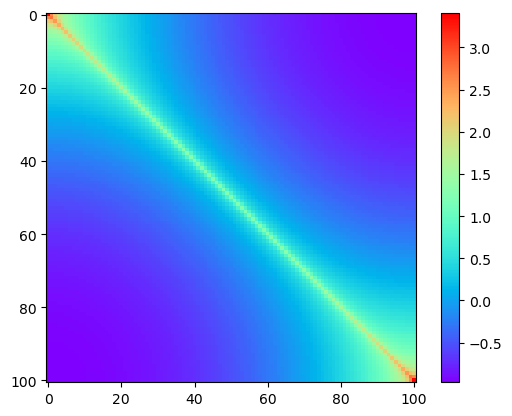

PyObject <matplotlib.colorbar.Colorbar object at 0x7f871ad5c2e0>

In [82]:
κ = test([(x, y)->250.0], 100)
PyPlot.figure()
PyPlot.imshow(κ[:,:,1], cmap=:rainbow)
PyPlot.colorbar()

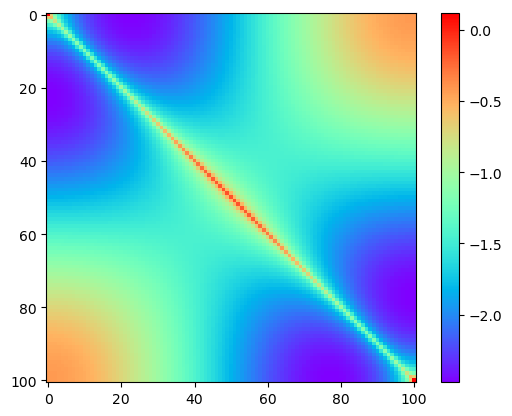

PyObject <matplotlib.colorbar.Colorbar object at 0x7f8722defeb0>

In [83]:
κ = test([(x, y)->300.0], 100)
PyPlot.figure()
PyPlot.imshow(κ[:,:,1], cmap=:rainbow)
PyPlot.colorbar()